# Loading the Data

In [ ]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#nltk
import string # used for preprocessing
import re # used for preprocessing
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords # used for preprocessing
from nltk.stem import WordNetLemmatizer # used for preprocessing
from nltk.probability import FreqDist #fr frquency count
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from tqdm import tqdm
import os

#preprocessing
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer,CountVectorizer
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,OrdinalEncoder,PowerTransformer,StandardScaler,normalize
from sklearn.model_selection import train_test_split, StratifiedKFold,KFold,TimeSeriesSplit,cross_val_score,GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.neighbors import LocalOutlierFactor
from sklearn.impute import SimpleImputer

# Classifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.svm import LinearSVC,SVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier
import xgboost as xgb
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#pip install lgm
from lightgbm import LGBMClassifier

# Metrics
from sklearn.metrics import roc_auc_score,make_scorer,classification_report,confusion_matrix,accuracy_score
from sklearn.multiclass import OneVsRestClassifier
import random
import torch

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/TrueFoundry/airline_sentiment_analysis.csv')
data

,Unnamed: 0,airline_sentiment,text
0,1,positive,@VirginAmerica plus you've added commercials t...
1,3,negative,@VirginAmerica it's really aggressive to blast...
2,4,negative,@VirginAmerica and it's a really big bad thing...
3,5,negative,@VirginAmerica seriously would pay $30 a fligh...
4,6,positive,"@VirginAmerica yes, nearly every time I fly VX..."
...,...,...,...
11536,14633,negative,@AmericanAir my flight was Cancelled Flightled...
11537,14634,negative,@AmericanAir right on cue with the delays👌
11538,14635,positive,@AmericanAir thank you we got on a different f...
11539,14636,negative,@AmericanAir leaving over 20 minutes Late Flig...


In [ ]:
data.columns

Index(['Unnamed: 0', 'airline_sentiment', 'text'], dtype='object')

In [ ]:
# Rename the "old_name" column to "new_name"
data = data.rename(columns={'Unnamed: 0': 'id'})
data.head()

,id,airline_sentiment,text
0,1,positive,@VirginAmerica plus you've added commercials t...
1,3,negative,@VirginAmerica it's really aggressive to blast...
2,4,negative,@VirginAmerica and it's a really big bad thing...
3,5,negative,@VirginAmerica seriously would pay $30 a fligh...
4,6,positive,"@VirginAmerica yes, nearly every time I fly VX..."


In [ ]:
data['airline_sentiment'] = data['airline_sentiment'].replace({'positive': 1, 'negative': 0})
data.head()

,id,airline_sentiment,text
0,1,1,@VirginAmerica plus you've added commercials t...
1,3,0,@VirginAmerica it's really aggressive to blast...
2,4,0,@VirginAmerica and it's a really big bad thing...
3,5,0,@VirginAmerica seriously would pay $30 a fligh...
4,6,1,"@VirginAmerica yes, nearly every time I fly VX..."


In [ ]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


# Preprocessing

In [ ]:
import nltk
# Uncomment to download "stopwords"
nltk.download("stopwords")
from nltk.corpus import stopwords

def text_preprocessing(s):
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Remove "@name"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    """
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove HTML encoding for < and >
    s = re.sub(r"&lt;", "<", s)
    s = re.sub(r"&gt;", ">", s)
    # Correct errors (eg. '&amp;' to '&')
    # Replace '&amp;' with '&'
    s = re.sub(r'&amp;', '&', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    '''
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    '''
    # Remove special characters
    s = re.sub(r"[^a-zA-Z0-9]", " ", s)
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    
    return s

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
t = data.text[1342]
t

'@united flight delayed...again...every time. "Maintenance issues"'

In [ ]:
# Print sentence 0
print('Original: ', t)
print('Processed: ', text_preprocessing(t))

Original:  @united flight delayed...again...every time. "Maintenance issues"
Processed:  flight delayed again every time maintenance issues


----------------------------

just doing some dry run to verify some queries....

In [ ]:
# preprocessing "@AmericanAir right on cue with the delays👌".
'''
import nltk
import re

def preprocess_text(text):
    # Remove Twitter handle
    text = re.sub(r"@\w+", "", text)

    # Remove special characters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)

    # Convert to lowercase
    text = text.lower()

    # Remove excess white space
    text = re.sub(r"\s+", " ", text)

    return text.strip()

text = "@AmericanAir right on cue with the delays👌"
cleaned_text = preprocess_text(text)
print(cleaned_text)  # Output: "right on cue with the delays"

'''

'\nimport nltk\nimport re\n\ndef preprocess_text(text):\n    # Remove Twitter handle\n    text = re.sub(r"@\\w+", "", text)\n\n    # Remove special characters\n    text = re.sub(r"[^a-zA-Z0-9]", " ", text)\n\n    # Convert to lowercase\n    text = text.lower()\n\n    # Remove excess white space\n    text = re.sub(r"\\s+", " ", text)\n\n    return text.strip()\n\ntext = "@AmericanAir right on cue with the delays👌"\ncleaned_text = preprocess_text(text)\nprint(cleaned_text)  # Output: "right on cue with the delays"\n\n'

continued.....

---------------------------

In [ ]:
t = data.airline_sentiment.values
t

array([1, 0, 0, ..., 1, 0, 0])

# EDA

[link text](https://www.kaggle.com/code/ananysharma/sentiment-analysis-using-bert)

In [ ]:
data.airline_sentiment.value_counts()

0    9178
1    2363
Name: airline_sentiment, dtype: int64

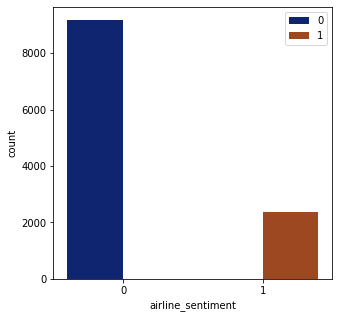

In [ ]:
plt.rcParams['figure.figsize'] = (5,5)
sns.countplot(data["airline_sentiment"],hue = data["airline_sentiment"],palette = 'dark')
plt.legend(loc = 'upper right')
plt.show()

In [ ]:
train_temp = data.copy(deep=True)

In [ ]:
unprocessed_X = list(train_temp["text"])
Y = list(train_temp["airline_sentiment"])

In [ ]:
preprocessed_X = np.array([text_preprocessing(text) for text in unprocessed_X])

In [ ]:
train = pd.DataFrame(list(zip(preprocessed_X, Y)), columns = ['text_a', 'labels'])
train.head()

,text_a,labels
0,plus you ve added commercials to the experienc...,1
1,it s really aggressive to blast obnoxious ente...,0
2,and it s a really big bad thing about it,0
3,seriously would pay 30 a flight for seats that...,0
4,yes nearly every time i fly vx this ear worm w...,1


**Analysing the words in sentences**

In [ ]:
text_len = []
for text in train.text_a:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

#train["text_len"] = train["text_a"].apply(lambda x: len(x)) || Do No Us
# _ t e

In [ ]:
train['text_len'] = text_len

In [ ]:
train.head()

,text_a,labels,text_len
0,plus you ve added commercials to the experienc...,1,9
1,it s really aggressive to blast obnoxious ente...,0,17
2,and it s a really big bad thing about it,0,10
3,seriously would pay 30 a flight for seats that...,0,24
4,yes nearly every time i fly vx this ear worm w...,1,14


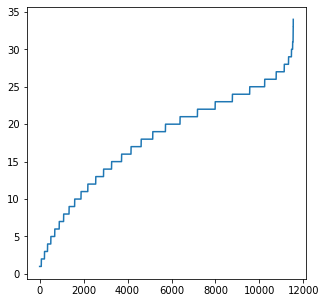

In [ ]:
lengths = pd.Series(sorted(train["text_len"]))
lengthsCount = pd.Series(sorted(train["text_len"])).value_counts()
lengths.plot()

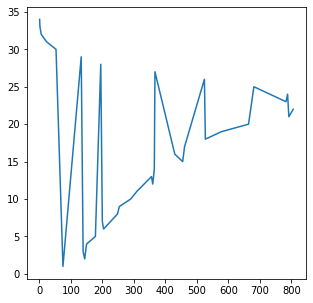

In [ ]:
plt.plot(lengthsCount,lengthsCount.index)

In [ ]:
lengths.median()# Max number of sentences are of ~20 words.

20.0

In [ ]:
lengths.describe()

count    11541.000000
mean        18.071744
std          6.794142
min          1.000000
25%         13.000000
50%         20.000000
75%         23.000000
max         34.000000
dtype: float64

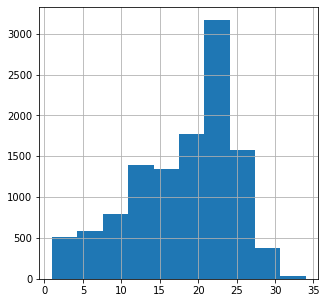

In [ ]:
train["text_a"].str.split().\
    map(lambda x: len(x)).\
    hist()

**Analysing the characters in sentences**

In [ ]:
train["text_character_len"] = train["text_a"].apply(lambda x: len(x))

In [ ]:
train.shape

(11541, 4)

In [ ]:
train.head()

,text_a,labels,text_len,text_character_len
0,plus you ve added commercials to the experienc...,1,9,53
1,it s really aggressive to blast obnoxious ente...,0,17,106
2,and it s a really big bad thing about it,0,10,40
3,seriously would pay 30 a flight for seats that...,0,24,120
4,yes nearly every time i fly vx this ear worm w...,1,14,58


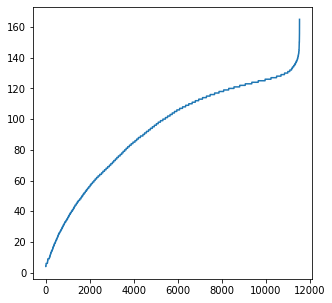

In [ ]:
lengths = pd.Series(sorted(train["text_character_len"]))
lengthsCount = pd.Series(sorted(train["text_character_len"])).value_counts()
lengths.plot()

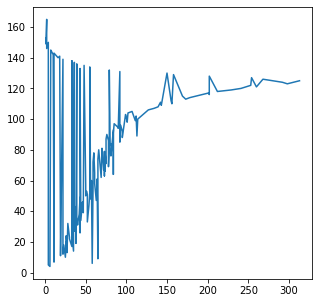

In [ ]:
plt.plot(lengthsCount,lengthsCount.index)

In [ ]:
lengths.median()# Max number of sentences are of ~104 words.

104.0

In [ ]:
lengths.describe()

count    11541.000000
mean        92.927823
std         33.901173
min          4.000000
25%         69.000000
50%        104.000000
75%        121.000000
max        165.000000
dtype: float64

------------------------------

* Here also most of the examples are less than 150 charector.
* That means a 250 word truncation will not be a problem for this data currently. Since we have a max length of 34 words in a sentence.

-----------------------------

In [ ]:
eval = pd.read_csv("/content/drive/MyDrive/TrueFoundry/eval_dataframe.csv")

mydf = pd.read_csv("/content/drive/MyDrive/TrueFoundry/mydf_dataframe.csv")

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 28.2 MB/s 
     |████████████████████████████████| 7.6 MB 49.0 MB/s 
     |████████████████████████████████| 182 kB 79.7 MB/s 


# BERT

In [ ]:
train_bert = data.copy(deep=True)

In [ ]:
train_bert = train_bert.rename(columns={'airline_sentiment': 'labels'})

In [ ]:
train_bert['text'] = train_bert['text'].apply(text_preprocessing)

In [ ]:
text_len = []
for text in train_bert.text:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

adding column for every text length

In [ ]:
train_bert['text_len'] = text_len

In [ ]:
# Importing stock ml libraries
import numpy as np
import pandas as pd
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig


import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

#data processing
import re, string
import nltk

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split


#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

#keras
import tensorflow as tf
from tensorflow import keras


#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

#set seed for reproducibility
seed=42

#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

<Figure size 432x288 with 0 Axes>

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
token_lens = []

for txt in train_bert['text'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    
max_len=np.max(token_lens)

In [ ]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 46


adding column for every token length

In [ ]:
train_bert['token_lens'] = token_lens

In [ ]:
train_bert.head()

,id,labels,text,text_len,token_lens
0,1,1,plus you ve added commercials to the experienc...,9,12
1,3,0,it s really aggressive to blast obnoxious ente...,17,23
2,4,0,and it s a really big bad thing about it,10,12
3,5,0,seriously would pay 30 a flight for seats that...,24,26
4,6,1,yes nearly every time i fly vx this ear worm w...,14,17


In [ ]:
!pip install -U sentence-transformers

In [ ]:
!pip install simpletransformers

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from simpletransformers.classification import (ClassificationModel, ClassificationArgs)
import pandas as pd
import logging

In [ ]:
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

In [ ]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [ ]:
train_new = data.copy(deep=True)

In [ ]:
train_new = train_new.iloc[np.random.permutation(len(train_new))] #shuffle
train_new = train_new.reset_index(drop=True)

In [ ]:
train_new['airline_sentiment'] = train_new['airline_sentiment'].astype(float)

In [ ]:
train_new.rename(columns={'text': 'text_a',
                          'airline_sentiment': 'labels'},
                           inplace=True, errors='raise')
train_new.head()

,id,labels,text_a
0,14401,0.0,@AmericanAir Worst airline ever. We have been ...
1,7581,1.0,@JetBlue it's only because I'm wearing #TrueBl...
2,11939,1.0,@AmericanAir @RobertDwyer AA doesnt charge any...
3,1723,0.0,"@united, maybe don't play the video about how ..."
4,10337,0.0,@USAirways #Wronganswer. Talk is cheap. Custom...


In [ ]:
#applying the preprocessing function
train_new['text_a'] = train_new['text_a'].apply(text_preprocessing)

In [ ]:
X = list(train_new["text_a"])
y = list(train_new["labels"])

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, stratify = y)


In [ ]:
mydf = pd.DataFrame(list(zip(X_train, y_train)), columns = ['text_a', 'labels'])
eval = pd.DataFrame(list(zip(X_val, y_val)), columns = ['text_a', 'labels'])

In [ ]:
mydf.to_csv (r'/content/drive/MyDrive/TrueFoundry/mydf_dataframe.csv', index = None, header=True) 
eval.to_csv (r'/content/drive/MyDrive/TrueFoundry/eval_dataframe.csv', index = None, header=True) 

In [ ]:
mydf.labels.value_counts()

0.0    7342
1.0    1890
Name: labels, dtype: int64

In [ ]:
eval.labels.value_counts()

0.0    1836
1.0     473
Name: labels, dtype: int64

In [ ]:
# Optional model configuration
model_args = ClassificationArgs(num_train_epochs=3)

# Create a ClassificationModel
model = ClassificationModel("bert","bert-base-cased")

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [ ]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
model_args = ClassificationArgs(num_train_epochs=5,overwrite_output_dir=True,train_batch_size=16,max_seq_length = 128,output_dir ="/content/drive/MyDrive/TrueFoundry/BERT_model")
# Create a ClassificationModel
model_1 = ClassificationModel(
     "bert","bert-base-cased",
    # "distilbert","distilbert-base-cased",
    #"roberta", "roberta-base",
    num_labels=2,
    args=model_args)
#df_train = df_train[["text_filt","aspect","label"]]
#df_train.columns = ["text_a", "text_b", "labels"]
model_1.train_model(mydf)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

  0%|          | 0/9232 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/577 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/577 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/577 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/577 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/577 [00:00<?, ?it/s]

(2885, 0.09645593753617186)

In [ ]:
pred,pred_prob = model_1.predict(eval[["text_a"]].values.tolist())

  0%|          | 0/2309 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

In [ ]:
pd.Series(pred).value_counts()

0    1869
1     440
dtype: int64

In [ ]:
eval["pred_bert"] = pred

In [ ]:
print(classification_report(eval["labels"],eval["pred_bert"]))

print("final-f1 = ",f1_score(eval["labels"],eval["pred_bert"]))

              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97      1836
         1.0       0.90      0.84      0.87       473

    accuracy                           0.95      2309
   macro avg       0.93      0.91      0.92      2309
weighted avg       0.95      0.95      0.95      2309

final-f1 =  0.8696604600219057


In [ ]:
from sklearn.metrics import matthews_corrcoef
print("the  Matthews correlation coefficient (MCC) score is =", matthews_corrcoef(eval["labels"],eval["pred_bert"]))

the  Matthews correlation coefficient (MCC) score is = 0.838444737914344


--------------
--------------

* **the final f1 score comes out to be 0.869**

* **the  Matthews correlation coefficient (MCC) score comes out to be 0.838**

--------------
--------------

# RoBERTa

In [ ]:
!pip install -U sentence-transformers

In [ ]:
!pip install simpletransformers

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from simpletransformers.classification import (ClassificationModel, ClassificationArgs)
import pandas as pd
import logging

In [ ]:
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

In [ ]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [ ]:
train_new = data.copy(deep=True)

In [ ]:
train_new.head()

,id,airline_sentiment,text
0,1,1,@VirginAmerica plus you've added commercials t...
1,3,0,@VirginAmerica it's really aggressive to blast...
2,4,0,@VirginAmerica and it's a really big bad thing...
3,5,0,@VirginAmerica seriously would pay $30 a fligh...
4,6,1,"@VirginAmerica yes, nearly every time I fly VX..."


In [ ]:
train_new = train_new.iloc[np.random.permutation(len(train_new))] #shuffle
train_new = train_new.reset_index(drop=True)

In [ ]:
train_new.head()

,id,airline_sentiment,text
0,8062,0,@JetBlue I ❤️ Jetblue but i was on flt 277 fro...
1,2535,0,@united i booked lh via ua. However at gate t...
2,10784,0,@USAirways I keep calling your help line (800)...
3,11360,1,@USAirways we haven't departed yet so let's no...
4,12748,0,@AmericanAir @USAirways need to be reported to...


In [ ]:
train_new['airline_sentiment'] = train_new['airline_sentiment'].astype(float)

In [ ]:
train_new.rename(columns={'text': 'text_a',
                          'airline_sentiment': 'labels'},
                           inplace=True, errors='raise')
train_new.head()

,id,labels,text_a
0,8062,0.0,@JetBlue I ❤️ Jetblue but i was on flt 277 fro...
1,2535,0.0,@united i booked lh via ua. However at gate t...
2,10784,0.0,@USAirways I keep calling your help line (800)...
3,11360,1.0,@USAirways we haven't departed yet so let's no...
4,12748,0.0,@AmericanAir @USAirways need to be reported to...


In [ ]:
X = list(train_new["text_a"])
y = list(train_new["labels"])

In [ ]:
X_preprocess = np.array([text_preprocessing(text) for text in X])

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_preprocess, y, test_size = 0.2, stratify = y)

#https://datascience.stackexchange.com/questions/40584/meaning-of-stratify-parameter

In [ ]:
mydf = pd.DataFrame(list(zip(X_train, y_train)), columns = ['text_a', 'labels'])
mydf.head()

,text_a,labels
0,18 flights so far this year 13 delays includin...,0.0
1,come back to phl already we need you to take u...,1.0
2,i understand ppl make mistakes but don not cod...,0.0
3,not very helpful trying to get out of nashvill...,0.0
4,you need to retrain your flight attendants say...,0.0


In [ ]:
mydf.labels.value_counts()

0.0    7342
1.0    1890
Name: labels, dtype: int64

In [ ]:
eval = pd.DataFrame(list(zip(X_val, y_val)), columns = ['text_a', 'labels'])
eval.head()

,text_a,labels
0,nice try at the gate making traveler after tra...,0.0
1,would love help getting there today in ewr now...,1.0
2,thanks for offering this service guys http t c...,1.0
3,im still waiting no answer,0.0
4,ceo battles to appease passengers and wall str...,0.0


In [ ]:
eval.labels.value_counts()

0.0    1836
1.0     473
Name: labels, dtype: int64

In [ ]:
# Optional model configuration
model_args = ClassificationArgs(num_train_epochs=3)

# Create a ClassificationModel
model = ClassificationModel("roberta", "roberta-base")

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
model_args = ClassificationArgs(num_train_epochs=5,overwrite_output_dir=True,train_batch_size=16,max_seq_length = 128,output_dir ="/content/drive/MyDrive/TrueFoundry/RoBERTa_model")
# Create a ClassificationModel
model_2 = ClassificationModel(
    # "bert","bert-base-cased",
    # "distilbert","distilbert-base-cased",
    "roberta", "roberta-base",
    num_labels=2,
    args=model_args)
#df_train = df_train[["text_filt","aspect","label"]]
#df_train.columns = ["text_a", "text_b", "labels"]
model_2.train_model(mydf)

#https://stackoverflow.com/questions/66600362/runtimeerror-cuda-error-cublas-status-execution-failed-when-calling-cublassge

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

  0%|          | 0/9232 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/577 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/577 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/577 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/577 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/577 [00:00<?, ?it/s]

(2885, 0.13330751421185053)

In [ ]:
pred,pred_prob = model_2.predict(eval[["text_a"]].values.tolist())

  0%|          | 0/2309 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

In [ ]:
pd.Series(pred).value_counts()

0    1844
1     465
dtype: int64

In [ ]:
eval["pred_roberta"] = pred

In [ ]:
print(classification_report(eval["labels"],eval["pred_roberta"]))

print("final-f1 = ",f1_score(eval["labels"],eval["pred_roberta"]))

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      1836
         1.0       0.90      0.89      0.89       473

    accuracy                           0.96      2309
   macro avg       0.94      0.93      0.93      2309
weighted avg       0.96      0.96      0.96      2309

final-f1 =  0.8933901918976547


https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-019-6413-7

In [ ]:
from sklearn.metrics import matthews_corrcoef
print("the  Matthews correlation coefficient (MCC) score is =", matthews_corrcoef(eval["labels"],eval["pred_roberta"]))

the  Matthews correlation coefficient (MCC) score is = 0.8662683733925758


--------------
--------------

* **the final f1 score comes out to be 0.893**

* **the  Matthews correlation coefficient (MCC) score comes out to be 0.866**

--------------
--------------

# XLnet

In [ ]:
!pip install -U sentence-transformers

In [ ]:
!pip install simpletransformers

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from simpletransformers.classification import (ClassificationModel, ClassificationArgs)
import pandas as pd
import logging

In [ ]:
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

In [ ]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [ ]:
# Optional model configuration
model_args = ClassificationArgs(num_train_epochs=3)

# Create a ClassificationModel
model_3 = ClassificationModel("xlnet", "xlnet-base-cased")

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

In [ ]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
model_args = ClassificationArgs(num_train_epochs=5,overwrite_output_dir=True,train_batch_size=16,max_seq_length = 128,output_dir ="/content/drive/MyDrive/TrueFoundry/XLNet_model")
# Create a ClassificationModel
model_3 = ClassificationModel(
     "xlnet", "xlnet-base-cased",
    num_labels=2,
    args=model_args)
#df_train = df_train[["text_filt","aspect","label"]]
#df_train.columns = ["text_a", "text_b", "labels"]
model_3.train_model(mydf)


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

  0%|          | 0/9232 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/577 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/577 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/577 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/577 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/577 [00:00<?, ?it/s]

(2885, 0.1388914712948444)

In [ ]:
pred,pred_prob = model_3.predict(eval[["text_a"]].values.tolist())

  0%|          | 0/2309 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

In [ ]:
pd.Series(pred).value_counts()

0    1863
1     446
dtype: int64

In [ ]:
eval["pred_XLNet"] = pred

In [ ]:
print(classification_report(eval["labels"],eval["pred_XLNet"]))
print("final-f1 = ",f1_score(eval["labels"],eval["pred_XLNet"]))

              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97      1836
         1.0       0.90      0.85      0.87       473

    accuracy                           0.95      2309
   macro avg       0.93      0.91      0.92      2309
weighted avg       0.95      0.95      0.95      2309

final-f1 =  0.8726877040261154


In [ ]:
from sklearn.metrics import matthews_corrcoef
print("the  Matthews correlation coefficient (MCC) score is =", matthews_corrcoef(eval["labels"],eval["pred_XLNet"]))

the  Matthews correlation coefficient (MCC) score is = 0.8416577220304712


--------------
--------------

* **the final f1 score comes out to be 0.872**

* **the  Matthews correlation coefficient (MCC) score comes out to be 0.841**

--------------
--------------

# ELECTRA

In [ ]:
# Optional model configuration
model_args = ClassificationArgs(num_train_epochs=3)

# Create a ClassificationModel
model_4 = ClassificationModel("electra", "google/electra-base-discriminator")

Downloading:   0%|          | 0.00/666 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.d

Downloading:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
model_args = ClassificationArgs(num_train_epochs=5,overwrite_output_dir=True,train_batch_size=16,max_seq_length = 128,output_dir ="/content/drive/MyDrive/TrueFoundry/ELECTRA_model")
# Create a ClassificationModel
model_4 = ClassificationModel(
     "electra", "google/electra-base-discriminator",
    num_labels=2,
    args=model_args)
#df_train = df_train[["text_filt","aspect","label"]]
#df_train.columns = ["text_a", "text_b", "labels"]
model_4.train_model(mydf)

Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.d

  0%|          | 0/9232 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/577 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/577 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/577 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/577 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/577 [00:00<?, ?it/s]

(2885, 0.0982149426688148)

In [ ]:
pred,pred_prob = model_4.predict(eval[["text_a"]].values.tolist())

  0%|          | 0/2309 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

In [ ]:
pd.Series(pred).value_counts()

0    1863
1     446
dtype: int64

In [ ]:
eval["pred_ELECTRA"] = pred

In [ ]:

print(classification_report(eval["labels"],eval["pred_ELECTRA"]))
print("final-f1 = ",f1_score(eval["labels"],eval["pred_ELECTRA"]))


              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97      1836
         1.0       0.91      0.86      0.89       473

    accuracy                           0.96      2309
   macro avg       0.94      0.92      0.93      2309
weighted avg       0.95      0.96      0.95      2309

final-f1 =  0.8879216539717083


In [ ]:
from sklearn.metrics import matthews_corrcoef
print("the  Matthews correlation coefficient (MCC) score is =", matthews_corrcoef(eval["labels"],eval["pred_ELECTRA"]))

the  Matthews correlation coefficient (MCC) score is = 0.8606851991039749


--------------
--------------

* **the final f1 score comes out to be 0.887**

* **the  Matthews correlation coefficient (MCC) score comes out to be 0.860**

--------------
--------------

# DistilroBERT

In [ ]:
# Optional model configuration
model_args = ClassificationArgs(num_train_epochs=3)

# Create a ClassificationModel
model_5 = ClassificationModel("roberta", "distilroberta-base")

Downloading:   0%|          | 0.00/480 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.weight'

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
model_args = ClassificationArgs(num_train_epochs=5,overwrite_output_dir=True,train_batch_size=16,max_seq_length = 128,output_dir ="/content/drive/MyDrive/TrueFoundry/DistilroBERT_model")
# Create a ClassificationModel
model_5 = ClassificationModel(
     "roberta", "distilroberta-base",
    num_labels=2,
    args=model_args)
#df_train = df_train[["text_filt","aspect","label"]]
#df_train.columns = ["text_a", "text_b", "labels"]
model_5.train_model(mydf)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.weight'

  0%|          | 0/9232 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/577 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/577 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/577 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/577 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/577 [00:00<?, ?it/s]

(2885, 0.11476651249869857)

In [ ]:
pred,pred_prob = model_5.predict(eval[["text_a"]].values.tolist())

  0%|          | 0/2309 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

In [ ]:
pd.Series(pred).value_counts()

0    1868
1     441
dtype: int64

In [ ]:
eval["pred_DistilroBERT"] = pred

In [ ]:
print(classification_report(eval["labels"],eval["pred_DistilroBERT"]))
print("final-f1 = ",f1_score(eval["labels"],eval["pred_DistilroBERT"]))

              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97      1836
         1.0       0.91      0.85      0.88       473

    accuracy                           0.95      2309
   macro avg       0.93      0.91      0.92      2309
weighted avg       0.95      0.95      0.95      2309

final-f1 =  0.8752735229759301


In [ ]:
from sklearn.metrics import matthews_corrcoef
print("the  Matthews correlation coefficient (MCC) score is =", matthews_corrcoef(eval["labels"],eval["pred_DistilroBERT"]))

the  Matthews correlation coefficient (MCC) score is = 0.8453482425894857


--------------
--------------

* **the final f1 score comes out to be 0.875**

* **the  Matthews correlation coefficient (MCC) score comes out to be 0.845**

--------------
--------------

In [ ]:
eval

,text_a,labels,pred_bert,pred_roberta,pred_XLNet,pred_ELECTRA,pred_DistilroBERT
0,no we are at a hotel also jetblue lost my daug...,0.0,0,0,0,0,0
1,your hold music needs 2 be fixed certain track...,0.0,0,0,0,0,0
2,you delayed our departure by 2 hrs to wait for...,0.0,0,0,0,0,0
3,some people in line have been waiting 55 minut...,0.0,0,0,0,0,0
4,i certainly understand the hold delays for wx ...,0.0,0,0,0,0,0
...,...,...,...,...,...,...,...
2304,thank you you do the same,1.0,1,1,1,1,1
2305,that guy really has no customer service clue c...,0.0,0,0,0,0,0
2306,time for a rant you delayed my flight and stil...,0.0,0,0,0,0,0
2307,45 minutes after arrival and no bags for most ...,0.0,0,0,0,0,0
